In [1]:
import platform
assert platform.system() == 'Darwin'

In [2]:
from pathlib import Path
import numpy as np
import coremltools as ct
from PIL import Image

In [3]:
def preprocess(img):
    img = img.astype(np.float) / 255
    img[0] -= 0.406
    img[1] -= 0.457
    img[2] -= 0.480
    img = img.transpose([2, 0, 1])[None, :, :, :]
    return img

raw_img = np.array(Image.open("test_img.png"))
img = preprocess(raw_img)

In [4]:
export_dir = Path("export")
export_dir.mkdir(exist_ok=True)
model_path = export_dir / "fast_res50_256x192.mlmodel"
model_output_path = export_dir / "fast_res50_256x192.mlmodel_torch_out.pkl"
model = ct.models.MLModel(str(model_path))

In [5]:
out = model.predict({"image": img})

In [6]:
import pickle

In [7]:
with open(model_output_path, "rb") as f: 
    torch_output = pickle.load(f, encoding="etf8")

deform_conv_cuda unavaliable
deform_pool_cuda unavaliable


In [8]:
error = abs(out['joints'] - torch_output.joints_map.detach().numpy())
error.mean(), error.max()

(8.879516e-05, 0.0032141209)

In [9]:
error = abs(out['radius'] - torch_output.joints_radius.detach().numpy())
error.mean(), error.max()

(6.0833554e-05, 0.00019061938)

# Visualization

In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import cv2

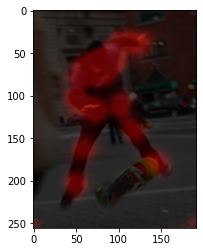

In [13]:
output_map = out['joints']

output_image = (0.25 * raw_img) / 255
output_map = F.interpolate(torch.Tensor(output_map), scale_factor=4, mode='bilinear', align_corners=False).numpy()
output_map = output_map[0]
output_image[:, :, 0] += 0.75 * output_map.sum(0).clip(0, 0.5)

plt.imshow(output_image)

In [14]:
coords = []
for map in output_map:
    if map.max() == 0:
        coords.append(None)
        continue
    c = np.unravel_index(map.argmax(), map.shape)
    coords.append(c)

In [15]:
keypoints_image = raw_img.copy()
joint_radius = out['radius'][0]
for coord, radius in zip(coords, joint_radius):
    if coord is None:
        continue
    if radius < 0:
        radius = 0
    center = coord[1], coord[0]
    keypoints_image = cv2.circle(keypoints_image, center, int(radius * img.shape[-1]), (255, 0, 0), -1)

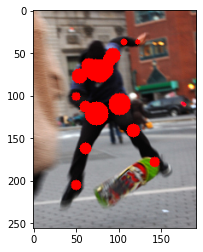

In [16]:
plt.imshow(keypoints_image)